# Assignment 1: k-nearest neighbors

Only use the already imported libraries `numpy` and `matplotlib.pyplot` for the assignment. Do not import any other library. 

In [1]:
# Load required packages and dataset. Do not modify.
import matplotlib.pyplot as plt
import numpy as np


def load_iris_dataset():
    from sklearn import datasets
    iris = datasets.load_iris()
    X = iris.data
    y = iris.target
    return X, y
    
X, y = load_iris_dataset()

## Task 1: Visualization and Preprocessing

1) Explain the content of the dataset in few words. What are the input features? What is the classification target? Check out: [https://en.wikipedia.org/wiki/Iris_flower_data_set](https://en.wikipedia.org/wiki/Iris_flower_data_set).


==> the dataset consists of flowers with three different classes and 4 interval features which are the length and width of sepals and petals 

2) Compute and print the following statistics about the dataset:
  - Number of samples
  - Number of samples per class
  - Mean and standard deviation for each input feature


In [2]:
np.random.seed(0)
print('dataset contains {} samples'.format(X.shape[0]))
classes,number_of_samples_per_class=np.unique(y,return_counts=True)
for i in range(len(number_of_samples_per_class)):
    print('class {} contains {} samples'.format(i,number_of_samples_per_class[i]))
for i in range(X.shape[1]):
    print('mean of feature {} is {}'.format(i,np.mean(X[:,i])))
    print('standard deviation of feature {} is {}'.format(i,np.std(X[:,i])))
    

dataset contains 150 samples
class 0 contains 50 samples
class 1 contains 50 samples
class 2 contains 50 samples
mean of feature 0 is 5.843333333333334
standard deviation of feature 0 is 0.8253012917851409
mean of feature 1 is 3.0540000000000003
standard deviation of feature 1 is 0.4321465800705435
mean of feature 2 is 3.758666666666666
standard deviation of feature 2 is 1.7585291834055212
mean of feature 3 is 1.1986666666666668
standard deviation of feature 3 is 0.7606126185881716


3) Visualize the variables Sepal length and Petal length in a scatter plot (Sepal length on the x-axis, petal length on the y-axis). Color each point of the plot according to its class.

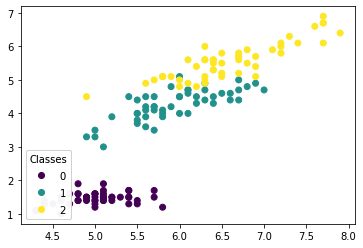

In [3]:
fig, ax = plt.subplots()
scatter = ax.scatter(X[:,0], X[:,2], c=y)
# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
legend2 = ax.add_artist(legend1)

4) Split the dataset randomly into training and test data. 70% of data should be used for training and 30% should be used for testing. Implement the function `train_test_split`. Do not modify the interface of the function.

In [4]:
def train_test_split(X, y):
    """
    Returns X_train, X_test, y_train, y_test, 
        where X_train and X_test are the input features of the training and test set,
        and y_train and y_test are the class labels of the training and test set.
    """
    X_train=[]
    y_train=np.array([],dtype=int)
    X_test=[]
    y_test=np.array([],dtype=int)

    for i in classes:
        
        class_mask=y==i
        X_class,y_class=X[class_mask],y[class_mask]
        indices = np.random.permutation(X_class.shape[0])
        X_train.append(X_class[indices[:int(0.7*X_class.shape[0])]])
        X_test.append(X_class[indices[int(0.7*X_class.shape[0]):]])
        y_train=np.append(y_train,y_class[indices[:int(0.7*X_class.shape[0])]])
        y_test=np.append(y_test,y_class[indices[int(0.7*X_class.shape[0]):]])
                        
    return np.vstack(X_train),np.vstack(X_test),y_train,y_test

X_train, X_test, y_train, y_test = train_test_split(X, y)


assert (X_train.shape[0] + X_test.shape[0]) == X.shape[0]
assert (y_train.shape[0] + y_test.shape[0]) == y.shape[0]
assert X_train.shape[1] == X_test.shape[1]

5) kNN uses a distance measure to identify close neighbors. If the input features are not of the same scale, the distance is not as meaningful, which can negatively impact classification performance. Perform min-max scaling (i.e. scale the values of the input features in such a way that their range is from 0 to 1) on the training and test data. Remember that you should only use information from the training data to perform the scaling on both data sets.

In [5]:
for i in range(X_train.shape[1]):
    feature_min=X_train[:,i].min()
    feature_max=X_train[:,i].max()
    X_train[:,i]=(X_train[:,i]-feature_min)/(feature_max-feature_min)
    X_test[:,i]=(X_test[:,i]-feature_min)/(feature_max-feature_min)


## Task 2: k-nearest neighbors

**For B.Sc. Data Science:**  
Implement the kNN algorithm with uniform weighting and arbitrary `k`. Fill out the `predict` method of class `KNearestNeighborsClassifier`. 

Use Euclidean distance to determine the nearest neighbors.
You can ignore the optional parameter `distance_metric`, which is provided as a field in the kNN class.

**For everyone else:**  
Implement the kNN algorithm with distance-based weighting and arbitrary `k`.
Fill out the `predict` method of class `KNearestNeighborsClassifier`.

The parameter `distance_metric` will either contain the string `uniform` or a function. If the value is `uniform`, the classifier should use the Euclidean distance for determining nearest neighbors and uniform weighting. If the value is a function, the classifier should use the function as distance metric and perform distance-weighted classification. An example distance metric is provided with `euclidean_distance`.

In [6]:
class KNearestNeighbors(object):
    def __init__(self, k, distance_metric='uniform'):
        self.k = k
        self.distance_metric = distance_metric
        
    def fit(self, X, y):
        """
        This functions saves the training data to be used during the prediction.
        """
        self.X = X
        self.y = y
    
    def predict(self, X):
        """
        Returns a vector of shape (n,) if X has shape (n,d), 
        where n is the number of samples and d is the number of features.
        """
        y=np.zeros(X.shape[0],dtype=int)
        distances=np.zeros(self.X.shape[0])
        sorted_distances_args=np.zeros(self.X.shape[0])
        for j in range(X.shape[0]):
            for i in range(self.X.shape[0]):
                if self.distance_metric=='uniform':
                    distances[i]=euclidean_distance(X[j],self.X[i])
                else:
                    distances[i]=self.distance_metric(X[j],self.X[i])
            k_min_distances_args=np.argsort(distances)[0:self.k]
            if self.distance_metric=='uniform':
                weights=np.ones_like(k_min_distances_args)
            else:
                epsilon = 1e-8
                weights=1.0/(distances[k_min_distances_args]+epsilon)
            y[j]=np.bincount(self.y[k_min_distances_args],weights).argmax()       
        return y

    
def euclidean_distance(x1, x2):
    """
    Given vectors x1 and x2 with shape (n,) returns distance between vectors as float.
    """
    return np.sqrt(np.sum((x1 - x2)*(x1 - x2)))

## Task 3: Evaluation

1) Implement functions to compute precision, recall and F1-score. `y_pred` and `y_true` are the vectors of predicted and true class labels respectively with shape `(n,)`, where `n` is the number of samples. Each function should return a float containing the corresponding score.

In [7]:
def precision(y_pred, y_true):
    y_concatenated=np.concatenate((y_pred[:,np.newaxis],y_true[:,np.newaxis]),axis=1)
    indecies_in_confustion,counts=np.unique(y_concatenated,return_counts=True,axis=0)
    confustion_matrix=np.zeros((classes.shape[0],classes.shape[0]))
    confustion_matrix[indecies_in_confustion[:,0],indecies_in_confustion[:,1]]=counts
    precision=np.zeros(classes.shape[0],dtype=float)
    for i in range(classes.shape[0]) :
        precision[i]=confustion_matrix[i,i]/np.sum(confustion_matrix[i,:])
    return np.mean(precision)

def recall(y_pred, y_true):
    y_concatenated=np.concatenate((y_pred[:,np.newaxis],y_true[:,np.newaxis]),axis=1)
    indecies_in_confustion,counts=np.unique(y_concatenated,return_counts=True,axis=0)
    confustion_matrix=np.zeros((classes.shape[0],classes.shape[0]))
    confustion_matrix[indecies_in_confustion[:,0],indecies_in_confustion[:,1]]=counts
    recall=np.zeros(classes.shape[0],dtype=float)
    for i in range(classes.shape[0]) :
        recall[i]=confustion_matrix[i,i]/np.sum(confustion_matrix[:,i])
    return np.mean(recall)

def f1score(y_pred, y_true):
    precision_arr=precision(y_pred,y_true)
    recall_arr=recall(y_pred,y_true)
    return 2*precision_arr*recall_arr/(precision_arr+recall_arr)

2) Evaluate the performance of kNN with uniform weighting on the Iris dataset for `k=1,3,5`. Train each of the `3` classifiers on the training data from Task 1. Perform the predictions on both the training and test data. Then compute precision, recall, and F1-score for each model and for both training and test data. Print all scores per model. What do you observe?

**For all students other than B.Sc. Data Science:** 
Evaluate the kNN classifier with Euclidean distance-weighting. Compare the performance to uniform-weighting. How does the performance change compared to uniform weighting for each `k`?

In [8]:
import time
start=time.time()
for k in [1,3,5]:
    classifier = KNearestNeighbors(k)
    classifier.fit(X_train,y_train)
    y_pred=classifier.predict(X_train)
    print('uniform classifier with k ={}'.format(k))
    print('\tprecision for training data : {}'.format(precision(y_pred,y_train)))
    print('\trecall for training data : {}'.format(recall(y_pred,y_train)))
    print('\tf1 score for training data : {}'.format(f1score(y_pred,y_train)))
    y_pred=classifier.predict(X_test)
    print('\tprecision for test data : {}'.format(precision(y_pred,y_test)))
    print('\trecall for test data : {}'.format(recall(y_pred,y_test)))
    print('\tf1 score for test data : {}'.format(f1score(y_pred,y_test)))
    classifier = KNearestNeighbors(k,distance_metric=euclidean_distance)
    classifier.fit(X_train,y_train)
    y_pred=classifier.predict(X_train)
    print('distance weighted classifier with k ={}'.format(k))
    print('\tprecision for training data : {}'.format(precision(y_pred,y_train)))
    print('\trecall for training data : {}'.format(recall(y_pred,y_train)))
    print('\tf1 score for training data : {}'.format(f1score(y_pred,y_train)))
    y_pred=classifier.predict(X_test)
    print('\tprecision for test data : {}'.format(precision(y_pred,y_test)))
    print('\trecall for test data : {}'.format(recall(y_pred,y_test)))
    print('\tf1 score for test data : {}'.format(f1score(y_pred,y_test)))
print(time.time()-start)

uniform classifier with k =1
	precision for training data : 1.0
	recall for training data : 1.0
	f1 score for training data : 1.0
	precision for test data : 0.9791666666666666
	recall for test data : 0.9777777777777779
	f1 score for test data : 0.9784717293588835
distance weighted classifier with k =1
	precision for training data : 1.0
	recall for training data : 1.0
	f1 score for training data : 1.0
	precision for test data : 0.9791666666666666
	recall for test data : 0.9777777777777779
	f1 score for test data : 0.9784717293588835
uniform classifier with k =3
	precision for training data : 0.9526143790849672
	recall for training data : 0.9523809523809524
	f1 score for training data : 0.9524976514316055
	precision for test data : 0.9791666666666666
	recall for test data : 0.9777777777777779
	f1 score for test data : 0.9784717293588835
distance weighted classifier with k =3
	precision for training data : 1.0
	recall for training data : 1.0
	f1 score for training data : 1.0
	precision fo

uniform weighting suffers from over fitting with low k and doesn't generalize correctly on test data. increaing k reduces overfitting yet if k is large it generalizes too much leading to poor results.
for distance based weighting results on train data is always the same m=because of the weights and the model generalizes better with increasing k without suffering from too much generalization as in uniform weightings. for k=1 both models behave similarly

3) Explain why kNN with `k=1` achieves perfect results on the training data. Why is it not the best model?

because with k=1 on training data its nearest neighbour would always be itself which means it gets always the correct label. However, this is not the best model because it suffferes from overfitting shich leads to poor generalization 